In [2]:
# no one: me gets fed up and rewrites the whole thing using chatgpt


# Initialization
import numpy as np
import matplotlib.pyplot as pl
from scipy import interpolate
from scipy import stats
import healpy as hp  # NOTE: you can neglect warning about version mismatch in CFITSIO if necessary 

N_side = 2048      # Both maps will have this N_side. Healpix map has 12 * N_side**2 pixels

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import pandas as pd
%matplotlib inline

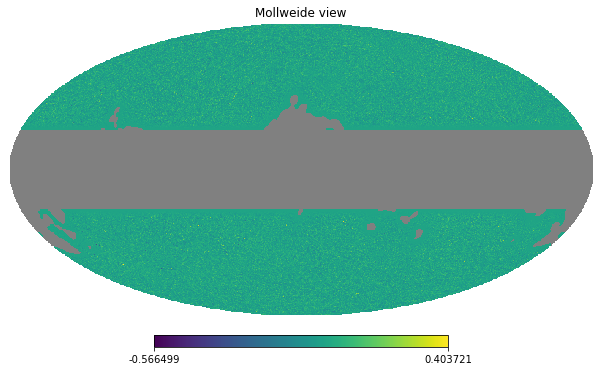

In [3]:
# Planck 2018 CIB map: http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits
CIB_map = hp.read_map('/Users/sophiarisin/Dropbox/Mac (2)/Desktop/research/cmb/catelogues/COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits')        # read CIB map
CIB_mask = hp.read_map('/Users/sophiarisin/Dropbox/Mac (2)/Downloads/cib_mask.fits')                                    # read CIB mask

CIB_masked = hp.ma(CIB_map)
CIB_masked.mask = np.logical_not(CIB_mask)
hp.mollview(CIB_masked)

In [164]:

from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

def read_nobs_pyfits(filename):
    with fits.open(filename, memmap=True) as hdul:
        data = (hdul[1].data)
        return np.shape(data)[0], hdul[1].columns.names

def read_test_pyfits(filename, colname):
    with fits.open(filename, memmap=True) as hdul:
        data = (hdul[1].data[colname])
        return data.copy()

def get_BOSS_data(gal):
    nObs, cols = read_nobs_pyfits(gal)
    colnames = [x for x in cols if x in ['ID', 'RA', 'DEC', 'Z', 'NZ', 'BOSS_SPECOBJ_ID',
                                         'BOSS_TARGET1', 'BOSS_TARGET2', 'EBOSS_TARGET0', 'ZOFFSET', 'TARGETOBJID',
                                         'OBJID', 'PLUG_RA', 'PLUG_DEC', 'Z']]
    ncols = len(colnames)
    myGalaxy = pd.DataFrame(data=np.zeros([nObs, ncols]), columns=colnames)
    for rowname in myGalaxy.columns:
        myGalaxy[rowname] = read_test_pyfits(gal, rowname).byteswap().newbyteorder()
    print(myGalaxy.columns)
    myGalaxy = myGalaxy.sort_values(by=['Z'])
    return myGalaxy



boss_catalog_path_s = '/Users/sophiarisin/Dropbox/Mac (2)/Desktop/research/cmb/catelogues/galaxy_DR12v5_CMASS_South.fits'
boss_catalog_path_n = '/Users/sophiarisin/Dropbox/Mac (2)/Desktop/research/cmb/catelogues/galaxy_DR12v5_CMASS_North.fits'
# Load the relevant entries of the catalog (we will be mostly concerned with RA, DEC, and redshift)
boss_catalog_s = get_BOSS_data(boss_catalog_path_s)
boss_catalog_n = get_BOSS_data(boss_catalog_path_n)

# Load the relevant entries of the catalog (we will be mostly concerned with RA, DEC, and redshift)
datas = get_BOSS_data(boss_catalog_path_s)
datan = get_BOSS_data(boss_catalog_path_n)
datas = pd.DataFrame(datas)
datasmodd = pd.DataFrame(datas[(datas.Z > .4) * (datas.Z < .5)])
datanmodd = pd.DataFrame(datan[(datan.Z > .4) * (datan.Z < .5)])

modtot = pd.concat([datanmodd,datasmodd])
modtot
#datas = np.where([(datas.Z > .4) * (datas.Z < .5)])
#datan= get_BOSS_data(boss_catalog_path_n)





Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')
Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')
Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')
Index(['RA', 'DEC', 'ID', 'Z', 'NZ'], dtype='object')


,RA,DEC,ID,Z,NZ
101614,247.318301,17.992327,730,0.400016,0.000030
217389,183.815674,5.735606,570,0.400019,0.000030
535616,173.541307,64.086510,437,0.400026,0.000030
390476,144.152138,31.079336,214,0.400026,0.000030
411144,137.651980,21.581740,571,0.400035,0.000030
...,...,...,...,...,...
175665,347.019901,10.235258,468,0.499996,0.000404
191200,353.141137,27.601397,667,0.499996,0.000404
124325,20.480020,23.182305,993,0.499997,0.000404
132305,331.410443,25.791790,1287,0.499998,0.000404


/var/folders/kk/rnqql9614nlc_8x0td93qcf40000gn/T/ipykernel_1035/3093361148.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gal_hpmap = np.zeros(npix, dtype=np.float)


222916.0
50331648


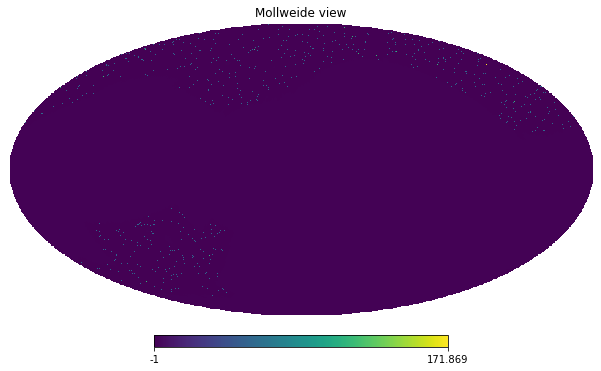

In [165]:

nside = 2048

npix = hp.nside2npix(nside)
# Go from HEALPix coordinates to indices, implicitly converting to galactic coordinates
c_icrs_s = SkyCoord(ra=modtot['RA']*u.degree, dec=modtot['DEC']*u.degree, frame='icrs')
indices = hp.ang2pix(nside, c_icrs_s.galactic.l.value, c_icrs_s.galactic.b.value, lonlat=True)
#c_icrs_n = SkyCoord(ra=datan['RA']*u.degree, dec=datan['DEC']*u.degree, frame='icrs')
#indices = hp.ang2pix(nside, c_icrs_n.galactic.l.value, c_icrs_n.galactic.b.value, lonlat=True)

# Initate the map and fill it with the values
gal_hpmap = np.zeros(npix, dtype=np.float)
# Assign sources to pixels
np.add.at(gal_hpmap, indices, 1)

print(np.sum(gal_hpmap))

#hp.mollview(gal_hpmap)

#redshift sorting
#  0.4<z<0.5, 0.5<z<0.6 and 0.6<z<0.8

'''bossdat = get_BOSS_data(boss_catalog_path_s)
Z = bossdat["Z"]
Z_bin1 = Z [(bossdat.Z > .4) * (bossdat.Z < .5)]
Z_bin2 = Z [(bossdat.Z > .5) & (bossdat.Z < .6)]
Z_bin3 = Z [(bossdat.Z > .6) & (bossdat.Z < .8)]

Z_bin1

bin1 = np.where([(bossdat.Z > .4) * (bossdat.Z < .5)])
bin1'''

def get_dn_from_map(gal_hpmap):
    ''' Convert a galaxy number map obtained using get_map_from_catalog() to one of fractional
        overdensity. Return also the mask
    ''' 
    #Total number counts. Should convert to delta_n/n. Make a mask first!
    gal_downgraded = hp.ud_grade(gal_hpmap, 64)
    gal_mask = np.zeros(len(gal_downgraded))
    gal_mask[(gal_downgraded > 0)] = 1
    nside = hp.npix2nside(len(gal_hpmap))
    gal_mask = hp.ud_grade(gal_mask, nside) # bring it back to the original resolution
    
    # Convert to delta_n / n (fractional fluctuations: this is what we can predict from theory)
    mean_gal = np.sum(gal_hpmap * gal_mask) / np.sum(gal_mask)
    gal_masked_dn = (gal_hpmap * gal_mask) / mean_gal - 1.
    gal_masked_dn = gal_mask * gal_masked_dn
    return gal_masked_dn, gal_mask


gal_dn, gal_mask = get_dn_from_map(gal_hpmap)

hp.mollview(gal_dn)

gal_dn.max()
print(npix)

# add the north 

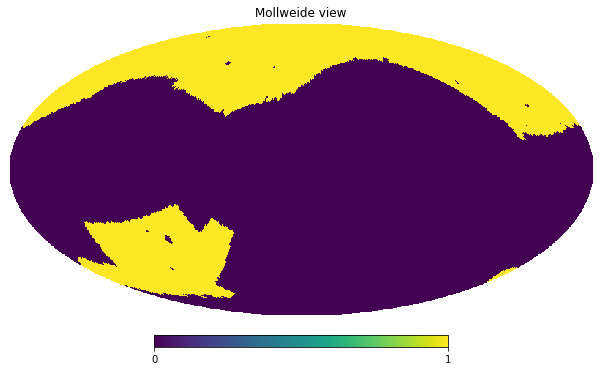

In [166]:
# CMASS map, total number counts. Should convert to delta_n/n. Make a mask first!
CMASS_map = gal_hpmap # mask should be made from regular density 
CMASS_downgraded = hp.ud_grade(CMASS_map, 64)
CMASS_mask = np.zeros(len(CMASS_downgraded))
CMASS_mask[(CMASS_downgraded > 0)] = 1
CMASS_mask = hp.ud_grade(CMASS_mask, N_side) # bring it back to the original resolution
hp.mollview(CMASS_mask,)
coord= ['G','C']

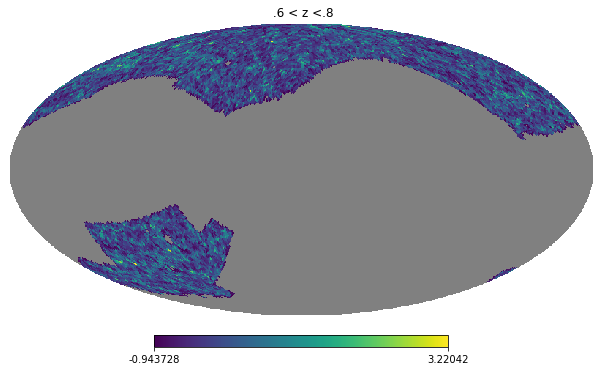

In [167]:
# Convert to a masked array for better plotting
CMASS_masked_dn = hp.ma(gal_dn)
CMASS_masked_dn.mask = np.logical_not(CMASS_mask)
hp.mollview(hp.ud_grade(CMASS_masked_dn,64), title =' .6 < z <.8')
#hp.mollview(hp.ud_grade(CMASS_masked_dn, 64))



In [168]:
# The "total" mask is product of PLANCK and CMASS masks
mask_tot = CMASS_mask * CIB_mask
fsky = np.sum(mask_tot) / len(mask_tot) # fsky for the cross-correlation
fsky_CIB = np.sum(CIB_mask) / len(CIB_mask)
fsky_CMASS = np.sum(CMASS_mask) / len(CMASS_mask)
print("f_sky cross = " + str(fsky))
print("f_sky CIB = " + str(fsky_CIB))
print("f_sky CMASS = " + str(fsky_CMASS))

f_sky cross = 0.249634150739921
f_sky CIB = 0.5787552197774252
f_sky CMASS = 0.2552083333333333


In [169]:
import csv

fitsname = 'boss_catalog_path_n'


List = [fitsname,fsky,fsky_CIB,fsky_CMASS]

with open('results.csv', 'a', newline ='') as f_object:
    writer = csv.writer(f_object)
    writer.writerow(List)
    f_object.close()

In [170]:
Cl_cross = hp.anafast(CIB_masked, map2 = CMASS_masked_dn, lmax = 2000)
ls = np.arange(len(Cl_cross))
pixwinf = hp.pixwin(N_side)[0:len(Cl_cross)]
# further divide by one power of beam
Cl_cross = Cl_cross / (pixwinf **2)                # Remove pixel window function
Cl_cross = Cl_cross / fsky                         # Undo the dilution caused by having observed only part of the sky

In [171]:
# Same as before!
Cl_CIB = hp.anafast(CIB_masked, lmax = 2000)
Cl_CMASS = hp.anafast(CMASS_masked_dn, lmax = 2000)
Cl_CIB = Cl_CIB / (pixwinf **2)
Cl_CMASS = Cl_CMASS / (pixwinf **2)
Cl_CIB = Cl_CIB / fsky_CIB
Cl_CMASS = Cl_CMASS / fsky_CMASS




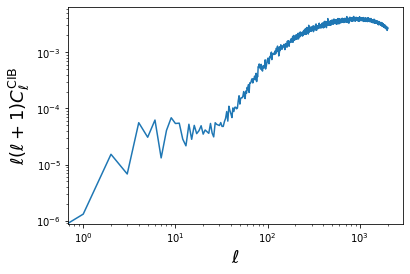

array([-4.20859968e-11,  6.04472692e-08])

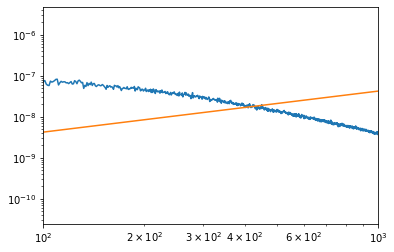

In [172]:
# Let's see what the CIB power spectrum looks like.  Note that it looks "noisy" because it's not yet binned! 
# Note that the normalization here is not quite right, since I am dividing by the f_sky of the overlap with galaxies,
# not the f_sky of the CIB map.  
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell (\ell+1) C_{\ell}^{\rm CIB}$', fontsize = 18)
pl.plot(ls, ls*(ls+1)* Cl_CIB)
# do the same binning like for the cross corrleation, and plot curve to just the cls 

def powerlawLOG(x,a):
    return(a*np.log(x))

# Let's see what the CIB power spectrum looks like.  Note that it looks "noisy" because it's not yet binned! 
# Note that the normalization here is not quite right, since I am dividing by the f_sky of the overlap with galaxies,
# not the f_sky of the CIB map.  
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell (\ell+1) C_{\ell}^{\rm CIB}$', fontsize = 18)
#pl.plot(ls, ls*(ls+1)* Cl_CIB)
#pl.plot(ls,powerlawLOG(ls,0.00041133))
pl.xscale('log')
pl.yscale('log')
pl.show()
# do the same binning like for the cross corrleation, and plot curve to just the cls 


pl.plot(ls,Cl_CIB)
plt.plot(ls,4.20859968e-11*ls)
pl.xlim(100,1000)
pl.xscale('log')
pl.yscale('log')
np.polyfit((ls),(Cl_CIB),1)


(array([  8.,  47., 272., 457., 115.]),
 array([-23.7650869 , -21.89512822, -20.02516954, -18.15521085,
        -16.28525217, -14.41529349]),
 <BarContainer object of 5 artists>)

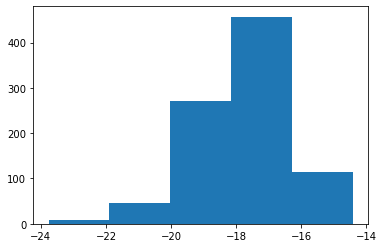

In [173]:
def lines(lolz,a,r):
    return(a*lolz+r)

def power(l,A,m):
    return( A * np.power(l,m))
#scipy.optimize.curve_fit(lines,ls,Cl_cross)

corrbins = pd.DataFrame({'l': ls, 'cl': Cl_cross, 'cib': Cl_CIB, 'cmass': Cl_CMASS})

#size it up 
things = (pd.DataFrame(corrbins[(corrbins.l > 100) * (corrbins.l < 1000)]))
things = things.dropna()
df = things.reset_index(drop=True)
dfo = abs(df)
dfo = np.log(dfo)


l = df['l']
llog = dfo['l']
cllog = dfo['cl']
#llog = np.log(l)
cl = df['cl']
cib = df['cib']
cmass = df['cmass']

#np.polyfit(l,cl,1)
np.polyfit(llog,cllog,1)
#scipy.optimize.curve_fit(lines,l,cl, p0=[-1.29576889,-9.8838181])
#scipy.optimize.curve_fit(power,l,cl, sigma = np.abs(cl) *np.sqrt(2/(2*l +1)))
plt.hist(cllog, bins = 5)

In [174]:
# FUCK CODE I HATE THIS SHIT

def binnedcross(c):
    cmax = max(c)
    cmin = min(c)
    clol = cmax - cmin
    clol = clol/5
    x = 0
    y = []
    while x < 5:
        c = clol + cmin
        cmin = c
        x = x+1
        y.append(c)
    return(y)

print(binnedcross(cllog))

dklhfas = dfo[(dfo.cl < -14.4)*(dfo.cl > -14.7)]
dklhfas




[-21.89512821974518, -20.025169536343224, -18.155210852941266, -16.28525216953931, -14.415293486137351]


,l,cl,cib,cmass
6,4.672829,-14.524826,-16.448000,-9.406446
16,4.762174,-14.527156,-16.521195,-9.383027
18,4.779123,-14.415293,-16.562713,-9.390805
19,4.787492,-14.564755,-16.505457,-9.407720
37,4.927254,-14.657729,-16.621835,-9.780713
60,5.081404,-14.690298,-16.782376,-9.887402
76,5.176150,-14.691727,-16.854074,-9.918452


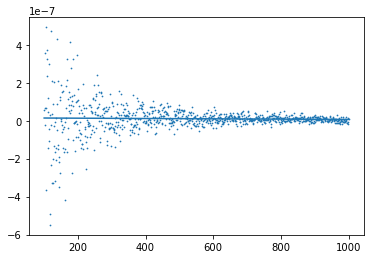

Text(0, 0.5, 'log of cl for cross correlation')

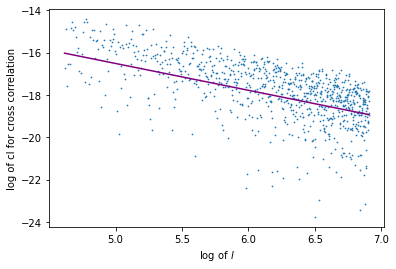

In [175]:
#pl.plot(llog,cib)
pl.scatter(l,cl, s = .5)
pl.plot(l,-8.24746982e-12*l+1.47438603e-08)
pl.show()

pl.scatter(llog,cllog, s =.5)
pl.plot(llog, -1.26815042*llog -10.16746575, c = 'purple')
pl.xlabel('log of $l$')
pl.ylabel('log of cl for cross correlation')

In [176]:
# lets do some binnin lol

Nbins = 5
lmin = 300
lmax = 1000

bins = np.round(np.linspace(lmin, lmax, Nbins+1))   # Bin edges
bins = bins.astype(int)
lcenterbin = np.zeros(len(bins)-1)
binned_cross = np.zeros(len(bins)-1)
binned_CIB = np.zeros(len(bins)-1)
binned_CMASS = np.zeros(len(bins)-1)

for k in range(0, len(bins)-1):  
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    lcenterbin[k] = np.round(0.5 * (bins[k] + bins[k+1]))   # bin center
    for l in lmaxvec:
        binned_cross[k] += Cl_cross[l]
    binned_cross[k] = binned_cross[k] / len(lmaxvec)

for k in range(0, len(bins)-1): 
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        binned_CIB[k] += Cl_CIB[l]
    binned_CIB[k] = binned_CIB[k] / len(lmaxvec)

for k in range(0, len(bins)-1): 
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        binned_CMASS[k] += Cl_CMASS[l]
    binned_CMASS[k] = binned_CMASS[k] / len(lmaxvec)

In [177]:
sigmavecth = np.zeros(len(bins)-1)
for k in range(0, len(bins)-1):
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        sigmavecth[k] += fsky * (2. * l + 1.) / (Cl_CIB[l] * Cl_CMASS[l] + Cl_cross[l]**2)
    sigmavecth[k] = 1. / sigmavecth[k]
sigmavecth = np.sqrt(sigmavecth)

np.polyfit(lcenterbin,lcenterbin*binned_cross,1)

array([-6.98148644e-10,  7.28263228e-06])

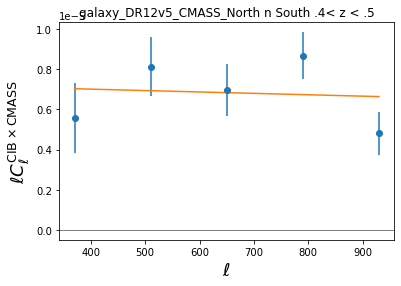

In [179]:
pl.errorbar(lcenterbin, lcenterbin * binned_cross, yerr = lcenterbin * sigmavecth, fmt = 'o', label = 'Data')
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell C_{\ell}^{{\rm CIB} \times {\rm CMASS}}$', fontsize = 18)
pl.axhline(y = 0 , color = 'k', lw = 0.5)
#pl.xlim([lmin, lmax])
#pl.ylim([0,1e-5])
plt.title('galaxy_DR12v5_CMASS_North n South .4< z < .5')
pl.plot(lcenterbin,-6.98148644e-10*lcenterbin+ 7.28263228e-06)
pl.show()

Text(0, 0.5, 'cl_cross log')

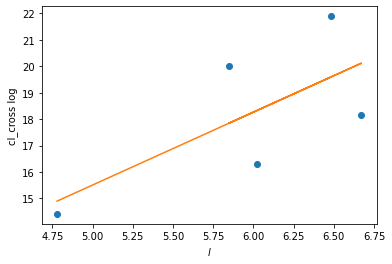

In [114]:
aaaa = [21.89512821974518, 20.025169536343224, 18.155210852941266, 16.28525216953931, 14.415293486137351]
hhhh = np.array([6.480216,5.846439,6.672033,6.0208025,4.779123])


plt.errorbar(hhhh,aaaa, yerr =(hhhh * sigmavecth), fmt ='o')
plt.plot(hhhh, 2.75778001 * hhhh + 1.71960676)
np.polyfit(hhhh,aaaa,1)
plt.xlabel('$l$')
plt.ylabel('cl_cross log')

In [186]:
np.polyfit(lcenterbin,binned_cross,1)

array([-1.76666663e-11,  2.30546700e-08])

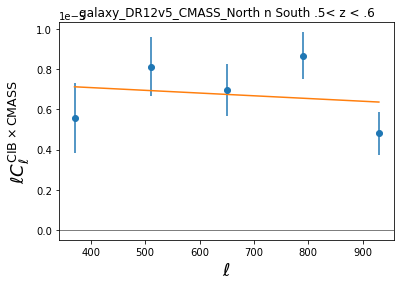

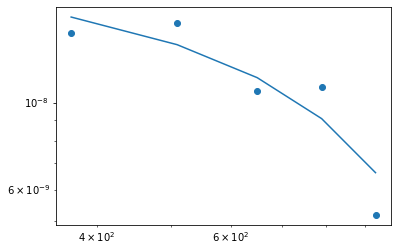

In [188]:
pl.errorbar(lcenterbin, lcenterbin * binned_cross, yerr = lcenterbin * sigmavecth, fmt = 'o', label = 'Data')
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell C_{\ell}^{{\rm CIB} \times {\rm CMASS}}$', fontsize = 18)
pl.axhline(y = 0 , color = 'k', lw = 0.5)
#pl.xlim([lmin, lmax])
#pl.ylim([0,1e-5])
plt.title('galaxy_DR12v5_CMASS_North n South .5< z < .6')
pl.plot(lcenterbin,-1.35615942e-09*lcenterbin+ 7.62271682e-06)
pl.show()
pl.scatter(lcenterbin,binned_cross)
pl.plot(lcenterbin, -1.76666663e-11 * lcenterbin +2.30546700e-08)
pl.xscale('log')
pl.yscale('log')

In [131]:
# things to work on/add -> redshift bins for what they said, north and south comparason, the stats things 
# figure out how to save the maps nicely

# look up scale where the dust dominates from our own galaxy, lmin of 100 should generally be good 
# fit a simple power law Al^alpha and compute error, could also look at the autocorrelation 
# add in quadreture?, change l max to a variable

In [ ]:
# fix the binning
#mcmc the shit <3 

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner


In [181]:
def model():
    '''
    all code ever
    model = # formulaes and things
    '''
    # 0.0
    
    return model

In [ ]:
def lnlike():
lnlike = # formula
return lnlike

def lnprior():
    if # conditions()
        return 0.0
    else:
        return -np.inf

def lnprob():